In [3]:
! pip install SimpleITK
! pip install nibabel

In [4]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


In [5]:
%run "utils.ipynb"

# %run "C:\Users\johnm\Downloads\utils.ipynb"  #tarang

# Visualizing one image

In [6]:
image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM
# image = sitk.ReadImage("../data/picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory EMILIA

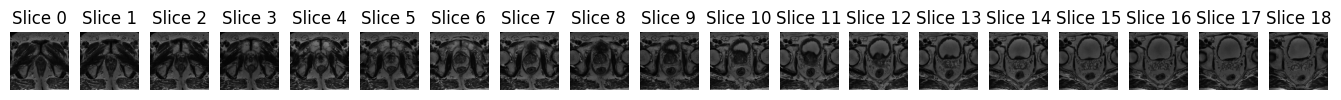

In [7]:
#this is to display the image
image_array = sitk.GetArrayFromImage(image)

# Display slices of the image using Matplotlib
num_slices = image_array.shape[0]  # Assuming the first dimension is the number of slices
fig, axes = plt.subplots(1, num_slices, figsize=(17, 4))
for i in range(num_slices):
    axes[i].imshow(image_array[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i}")
plt.show()

# Image preprocessing

## Merging images with label in one dictionary

In [8]:
directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
# directory = "../data/picai_public_images_fold1"
# directory = "../data/image/"

In [9]:
# tarang updated this to make it a function

def make_dict(directory, multi_fold = False, dict_images = {}):

  if multi_fold:
    print('fold')
    folds = os.listdir(directory)
    for f in folds:
      fold_path = os.path.join(directory, f)
      print(fold_path)
      make_dict(fold_path, False, dict_images)
    return dict_images
  else:
    print('datapoint')
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if "t2w" in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'age_group': None, 'patient_id': None}
    return dict_images


In [10]:
dict_images = {}

# previous code:

#one folder only
# dict_images = make_dict(directory, False, dict_images)

# all folders
dict_images = make_dict(directory, True, dict_images)

fold
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10268
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10892
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/11385
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10401
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/11371
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10895
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/11376
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10096
datapoint
/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10250
datapoint
/Users/kimberlyllajarunaperalta/

In [11]:
# dict_images = {}

# # previous code:
# #dict_images = make_dict(directory, False, dict_images)

# # updating this to what works for me, change it back to directory and False when running

# #from google.colab import drive
# #drive.mount('/content/drive')

# directory = "D:\Downloads\Luna Training Data"
# folds = os.listdir(directory)

# print(folds)

# dict_images = make_dict(directory, True, dict_images)

In [12]:
print(list(dict_images.keys())[0])

dict_images[list(dict_images.keys())[0]]

IndexError: list index out of range

In [ ]:
#size of the dictionary
len(dict_images)

0

We stored 3 things:
* the nii files that have the color coded images
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

## Opening nii files

In [ ]:
# path = '../10035_1000035.nii'


In [ ]:
# img = nib.load(path).get_fdata()
# img.shape

In [ ]:
# print(f"The .nii files are stored in memory as numpy's: {type(img)}.")


In [ ]:
# plt.style.use('default')
# fig, axes = plt.subplots(4,4, figsize=(12,12))
# for i, ax in enumerate(axes.reshape(-1)):
#     ax.imshow(img[:,:,1 + i])
# plt.show()

## Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [16]:
# tarang

# drive.flush_and_unmount()

labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"

In [17]:
labels_path = "../marksheet.csv"
# labels_path = "../data/marksheet.csv"

In [18]:
df = pd.read_csv(labels_path)

In [19]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [20]:
df['case_csPCa'].value_counts()

NO     1075
YES     425
Name: case_csPCa, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [21]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [22]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [23]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

### Creating a new variable for age group (multimodal purposes)

In [24]:
def categorize_age(age):
    if age < 65:
        return '<65'
    else:
        return '65+'

# Apply the function to create a new column for age group
df['age_group'] = df['patient_age'].apply(categorize_age)

# Count occurrences of each age group
age_group_counts = df['age_group'].value_counts()

# Display the counts
print(age_group_counts)

65+    869
<65    631
Name: age_group, dtype: int64


## Adding to a dictionary based on their full name

In [25]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f
        
        age_group = categorize_age(patient_age)
        dict_images[f]['age_group'] = age_group

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Could not find 10008_1000008
Could not find 10009_1000009
Could not find 10010_1000010
Could not find 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Could not find 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Could not find 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Could not find 10024_1000024
Could not find 10025_1000025
Could not find 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Could not find 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find

In [26]:
found, not_found

(0, 1500)

In [27]:
dict_images

{}

### Evaluating class imbalance in final sample

In [28]:



# ### THIS HAS ALL BEEN PUT INTO FUNCTIONS BELOW BECAUSE IT WAS NEEDED FOR THE YOUNG/OLD DICTS AS WELL :) 




# # Extract 'case_pca' values from dictionary values
# case_pca_values = [item['case_pca'] for item in dict_images.values()]

# # Count occurrences of 'YES' and 'NO'
# counts = Counter(case_pca_values)
# yes_count = counts[1]
# no_count = counts[0]

# print(f"Count of 'YES': {yes_count}")
# print(f"Count of 'NO': {no_count}")

# # trying to balance
# balanced = {}

# positives = {}
# for k in dict_images.keys():
#   balanced[k] = dict_images[k]
#   if dict_images[k]['case_pca'] == 1:
#     positives[k] = dict_images[k]

# repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

# for r in range(len(repeats)):
#   balanced[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]
#   print("repeating " + repeats[r])

# # check if correctly done
# case_pca_values = [item['case_pca'] for item in balanced.values()]

# # Count occurrences of 'YES' and 'NO'
# counts = Counter(case_pca_values)
# yes_count = counts[1]
# no_count = counts[0]

# print(f"Count of 'YES': {yes_count}")
# print(f"Count of 'NO': {no_count}")

In [29]:
def balance_checker(current_dictionary, return_counts = False):
    # Extract 'case_pca' values from dictionary values
    case_pca_values = [item['case_pca'] for item in current_dictionary.values()]

    # Count occurrences of 'YES' and 'NO'
    counts = Counter(case_pca_values)
    yes_count = counts[1]
    no_count = counts[0]
    
    if return_counts:
        return yes_count, no_count
    else:
        print(f"Count of 'YES': {yes_count}")
        print(f"Count of 'NO': {no_count}")


# def balance_dataset(current_dictionary):
#     yes_count, no_count = balance_checker(current_dictionary, return_counts = True)
#     balanced_dic = {}
#     positives = {}
#     for k in current_dictionary.keys():
#         balanced_dic[k] = current_dictionary[k]
#         if current_dictionary[k]['case_pca'] == 1:
#             positives[k] = current_dictionary[k]

#     repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

#     for r in range(len(repeats)):
#         balanced_dic[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]
#         # print("Repeating " + repeats[r])
        
#     return balanced_dic

In [30]:
def balance_dataset(current_dictionary, sampling='upsampling'):
    yes_count, no_count = balance_checker(current_dictionary, return_counts=True)
    balanced_dic = {}
    positives = {}
    for k in current_dictionary.keys():
        balanced_dic[k] = current_dictionary[k]
        if current_dictionary[k]['case_pca'] == 1:
            positives[k] = current_dictionary[k]

    if sampling == 'upsampling':
        repeats = random.choices(list(positives.keys()), k = no_count - yes_count)

        for r in range(len(repeats)):
            balanced_dic[str(repeats[r]) + "r" + str(r)] = positives[repeats[r]]
            
            
    elif sampling == 'downsampling':
        # If downsampling, randomly remove instances from the majority class
        if no_count > yes_count:
            to_remove = random.sample([k for k, v in balanced_dic.items() if v['case_pca'] == 0], no_count - yes_count)
            for key in to_remove:
                del balanced_dic[key]
    
    return balanced_dic

In [31]:
balanced = balance_dataset(dict_images)

In [32]:
balance_checker(dict_images)

Count of 'YES': 0
Count of 'NO': 0


In [33]:
balance_checker(balanced)

Count of 'YES': 0
Count of 'NO': 0


In [34]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{}

In [35]:
# balanced dictionary

balanced

{}

In [36]:
dict_images[list(dict_images.keys())[0]]

IndexError: list index out of range

## Image Processing and Train Test Split

In [37]:
def preprocess_data(data , forresnet):
    images, labels, ages = [], [], []

    for entry in data.values():
        image = forresnet(entry['image'])
        label = entry['case_pca']
        age = entry['patient_age']
        images.append(image)
        labels.append(label)
        ages.append(age)

    X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size = 0.2, random_state = 42)
    X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size = 0.2, random_state = 42)

    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    age_train = np.array(age_train)
    age_val = np.array(age_val)
    age_test = np.array(age_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test

In [38]:
X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test = preprocess_data(balanced, forresnet)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Evaluating class imbalance in train, test, and validation sets

In [ ]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({1: 697, 0: 679})
Validation Label Counts: Counter({0: 175, 1: 169})
Test Label Counts: Counter({0: 221, 1: 209})


In [ ]:
X_train.shape, X_val.shape, X_test.shape

((1376, 224, 224, 3), (344, 224, 224, 3), (430, 224, 224, 3))

# Experiment 1 - Baseline Model: ResNet50

In [ ]:
# model = tf.keras.applications.ResNet50()

In [ ]:
# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10


2024-05-11 10:16:16.315724: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - 9s 822ms/step - loss: 0.7309 - accuracy: 0.5674 - val_loss: 0.6506 - val_accuracy: 0.5211
Epoch 2/10
9/9 [==============================] - 7s 742ms/step - loss: 0.6598 - accuracy: 0.5638 - val_loss: 0.6207 - val_accuracy: 0.5915
Epoch 3/10
9/9 [==============================] - 6s 729ms/step - loss: 0.5885 - accuracy: 0.6667 - val_loss: 0.6028 - val_accuracy: 0.6056
Epoch 4/10
9/9 [==============================] - 7s 843ms/step - loss: 0.5625 - accuracy: 0.6809 - val_loss: 0.6751 - val_accuracy: 0.6761
Epoch 5/10
9/9 [==============================] - 7s 789ms/step - loss: 0.5340 - accuracy: 0.7163 - val_loss: 0.5904 - val_accuracy: 0.6056
Epoch 6/10
9/9 [==============================] - 7s 758ms/step - loss: 0.5014 - accuracy: 0.7447 - val_loss: 0.5939 - val_accuracy: 0.6056
Epoch 7/10
9/9 [==============================] - 7s 751ms/step - loss: 0.4745 - accuracy: 0.7837 - val_loss: 0.5707 - val_accuracy: 0.6620
Epoch 8/10
9/9 [===============

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3/3 [==============================] - 2s 537ms/step - loss: 0.6180 - accuracy: 0.6517
Test accuracy: 0.6516854166984558


## Performance Evaluation

3/3 [==============================] - 2s 541ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.797872,0.721053,0.971631,0.827795
Validation,0.732394,0.651163,0.875000,0.746667
Test,0.651685,0.626866,0.875000,0.730435


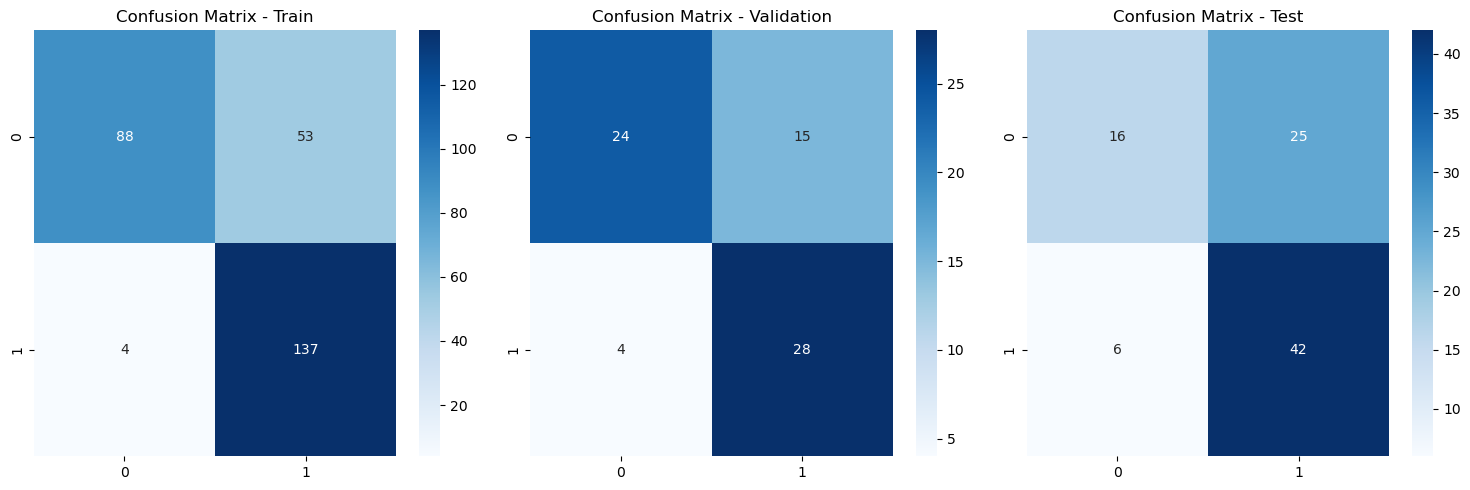

In [ ]:
metrics_df = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

# Experiment 2

## Experiment 2.1: Concatenate the images

Instead of treating
image types separately, we concatenate a single slice
from each image type (T2W, DWI, and ADC) into a
single input that is passed onto the ResNet-50 model,
providing a more holistic view of the patient’s MRI


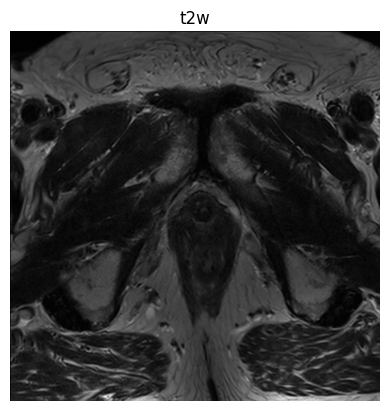

In [39]:
## getting the images together before hand , this is the 
image= sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_t2w.mha") #need to add ../ to go up one directory KIM

#this is to display the image
image_array_1 = sitk.GetArrayFromImage(image)

first_slice = image_array_1[0]  # Selecting the first slice
plt.imshow(first_slice, cmap='gray')
plt.axis('off')
plt.title("t2w")
plt.show()

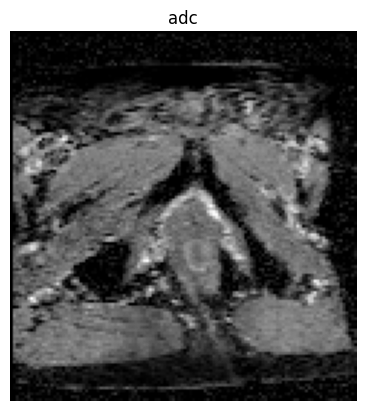

In [40]:
## getting the images together before hand , this is the 
image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_adc.mha") #need to add ../ to go up one directory KIM

#this is to display the image
image_array_2 = sitk.GetArrayFromImage(image)

first_slice = image_array_2[0]  # Selecting the first slice
plt.imshow(first_slice, cmap='gray')
plt.axis('off')
plt.title("adc")
plt.show()

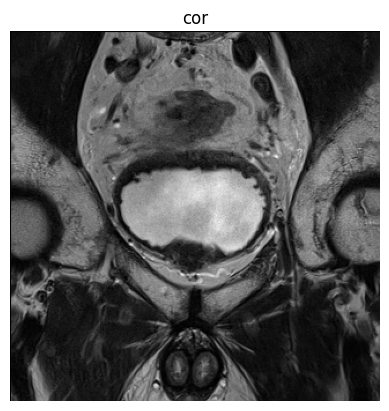

In [41]:
## getting the images together before hand , this is the 
image = sitk.ReadImage("../picai_public_images_fold1/10010/10010_1000010_cor.mha") #need to add ../ to go up one directory KIM

#this is to display the image
image_array_3 = sitk.GetArrayFromImage(image)

first_slice = image_array_3[0]  # Selecting the first slice
plt.imshow(first_slice, cmap='gray')
plt.axis('off')
plt.title("cor")
plt.show()

In [42]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

# Define the directory containing the images
directory = "../picai_public_images_fold1"

dict_images_combined = {}
# Initialize an empty list to store the concatenated images for each folder
concatenated_images_list = []

# Iterate through the directories in the main directory
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if os.path.isdir(folder_path): #this is for each folder
        first_slices = []
        # Iterate through the files in the subdirectory
        for file_name in os.listdir(folder_path):
            #this is for the name of the dic
            full_path = os.path.join(folder_path, file_name)
            if os.path.exists(full_path):
                short_name = '_'.join(file_name.split('_')[:2])

            if "t2w" in file_name and file_name.endswith('.mha'):
                # Read the image
                image = sitk.ReadImage(full_path)
                # Get the first slice
                first_slice = sitk.GetArrayFromImage(image)[0]
                first_slices.append(first_slice)
            elif "adc" in file_name and file_name.endswith('.mha'):
                # Read the image
                image = sitk.ReadImage(full_path)
                # Get the first slice
                first_slice = sitk.GetArrayFromImage(image)[0]
                first_slices.append(first_slice)
            elif "cor" in file_name and file_name.endswith('.mha'):
                # Read the image
                image = sitk.ReadImage(full_path)
                # Get the first slice
                first_slice = sitk.GetArrayFromImage(image)[0]
                first_slices.append(first_slice)
        
        # Find the maximum height among the first slices
        max_height = max(image.shape[0] for image in first_slices)
        
        # Resize all first slices to have the same height
        resized_first_slices = [np.pad(image, ((0, max_height - image.shape[0]), (0, 0)), mode='constant') for image in first_slices]
        
        # Concatenate the resized first slices along the horizontal axis (axis=1)
        concatenated_image = np.concatenate(resized_first_slices, axis=1)
        concatenated_images_list.append(concatenated_image)
        dict_images_combined[short_name] = {'image': concatenated_image, 'case_pca': None, 'patient_age': None, 'age_group': None, 'patient_id': None}

# # Display the concatenated image for each folder
# for i, image in enumerate(concatenated_images_list):
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')
#     plt.title(f"Concatenated Image for Folder {i}")
#     plt.show()


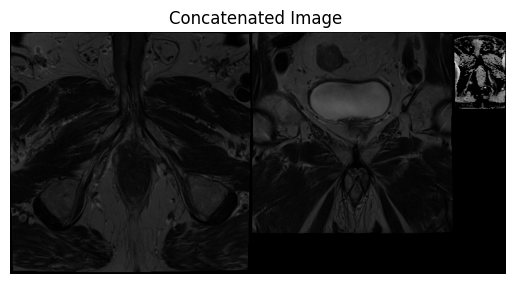

In [43]:
plt.imshow(concatenated_images_list[0], cmap='gray')
plt.axis('off')
plt.title(f"Concatenated Image ")
plt.show()

In [44]:
len(concatenated_images_list)

295

In [45]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images_combined:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images_combined[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images_combined[f]['patient_age'] = patient_age
        dict_images_combined[f]['patient_id'] = f
        
        age_group = categorize_age(patient_age)
        dict_images_combined[f]['age_group'] = age_group

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Found 10008_1000008
Could not find 10009_1000009
Found 10010_1000010
Found 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Found 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Found 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Found 10024_1000024
Could not find 10025_1000025
Found 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Found 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find 10034_1000034
Could not find 10035_1000035
Found 10036_1000036
Could no

In [46]:
dict_images_combined

{'10268_1000272': {'image': array([[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  2, ...,  0,  0,  0],
         [ 0,  2, 48, ...,  0,  0,  0],
         ...,
         [ 0,  1,  2, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16),
  'case_pca': 1,
  'patient_age': 76,
  'age_group': '65+',
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': array([[  0,   0,   0, ...,   0,   0,   0],
         [  0, 239, 226, ...,  71,  61,  63],
         [  0, 229, 221, ...,  44,  74,  75],
         ...,
         [  0, 437, 436, ...,   0,   0,   0],
         [  0, 431, 435, ...,   0,   0,   0],
         [  0, 438, 444, ...,   0,   0,   0]], dtype=uint16),
  'case_pca': 0,
  'patient_age': 64,
  'age_group': '<65',
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
        

In [47]:
balanced_combined = balance_dataset(dict_images_combined)

In [48]:
balance_checker(dict_images_combined)

Count of 'YES': 77
Count of 'NO': 218


In [49]:
balance_checker(balanced_combined)

Count of 'YES': 218
Count of 'NO': 218


In [50]:
def forresnet_combined(image_sample):
    """
    Preprocess the image for ResNet-50 model
    
    """
    # Assuming images[0] is a SimpleITK image
    image_array = image_sample

    # # Convert SimpleITK image to numpy array
    # image_array = sitk.GetArrayFromImage(image_sitk)  #single_slice
    # middle_slice_index = math.floor(image_array.shape[0] / 2)
    # image_array = image_array[middle_slice_index, :, :]
    print("Original shape:", image_array.shape)  # (384, 384)

    # Reshape to add an extra dimension
    image_array = np.expand_dims(image_array, axis=-1)
    print("Shape after adding dimension:", image_array.shape)  # (384, 384, 1)

    # Resize the image to (224, 224)
    image_array = tf.image.resize(image_array, (224, 224))
    print("Resized shape:", image_array.shape)  # (224, 224, 1)

    # Remove the extra dimension
    image_array = tf.squeeze(image_array, axis=-1)
    print("Shape after squeezing:", image_array.shape)  # (224, 224)
    
    # Convert to grayscale NOT NEEDED BECAUSE IT IS ALREADY IN GRAYSCALE
    # image_array = tf.image.rgb_to_grayscale(image_array)
    # print("Shape after converting to grayscale:", image_array.shape)  # (224, 224, 1)

    # Stack to create a 3-channel image
    image_array = tf.stack([image_array] * 3, axis=-1)
    print("Shape after stacking:", image_array.shape)  # (224, 224, 3)

    # Normalize the image
    image_array = image_array / 255.0
    print("Shape after normalization:", image_array.shape)

    # # Add batch dimension
    # image_array = tf.expand_dims(image_array, axis=0)
    # print("Final shape with batch dimension:", image_array.shape)

    return image_array

In [51]:
X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test = preprocess_data(balanced_combined, forresnet_combined)

Original shape: (384, 788)
Shape after adding dimension: (384, 788, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (640, 1080)
Shape after adding dimension: (640, 1080, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (1024, 2000)
Shape after adding dimension: (1024, 2000, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 824)
Shape after adding dimension: (384, 824, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 824)
Shape after adding dimension: (384, 824, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stac

Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 824)
Shape after adding dimension: (384, 824, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (1024, 2000)
Shape after adding dimension: (1024, 2000, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 788)
Shape after adding dimension: (384, 788, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (384, 788)
Shape after adding dimension: (384, 788, 1)
Resized shape: (224, 224, 1)
Shape after squeezing: (224, 224)
Shape after stacking: (224, 224, 3)
Shape after normalization: (224, 224, 3)
Original shape: (320, 896)
Shape after adding dimension: (320, 896, 1)
Resi

In [52]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)

Train Label Counts: Counter({0: 143, 1: 135})
Validation Label Counts: Counter({0: 36, 1: 34})
Test Label Counts: Counter({1: 49, 0: 39})


In [53]:
X_train.shape, X_val.shape, X_test.shape

((278, 224, 224, 3), (70, 224, 224, 3), (88, 224, 224, 3))

This is just the original model with the images concatenated.

In [54]:
# Load pre-trained ResNet-50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(128, activation='relu')(x)  # Add a dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

# Combine the base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [55]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val)) 

Epoch 1/10


9/9 [==============================] - 11s 1s/step - loss: 0.7160 - accuracy: 0.5540 - val_loss: 0.6954 - val_accuracy: 0.5286
Epoch 2/10
9/9 [==============================] - 8s 924ms/step - loss: 0.5967 - accuracy: 0.6691 - val_loss: 0.6969 - val_accuracy: 0.5429
Epoch 3/10
9/9 [==============================] - 8s 934ms/step - loss: 0.5508 - accuracy: 0.7086 - val_loss: 0.6741 - val_accuracy: 0.6143
Epoch 4/10
9/9 [==============================] - 8s 963ms/step - loss: 0.4911 - accuracy: 0.7626 - val_loss: 0.7025 - val_accuracy: 0.6143
Epoch 5/10
9/9 [==============================] - 8s 935ms/step - loss: 0.4767 - accuracy: 0.7518 - val_loss: 0.6809 - val_accuracy: 0.6429
Epoch 6/10
9/9 [==============================] - 8s 945ms/step - loss: 0.4489 - accuracy: 0.7950 - val_loss: 0.6618 - val_accuracy: 0.6714
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.4067 - accuracy: 0.8561 - val_loss: 0.6852 - val_accuracy: 0.6429
Epoch 8/10
9/9 [====================

In [56]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

3/3 [==============================] - 2s 798ms/step - loss: 0.5999 - accuracy: 0.7045
Test accuracy: 0.7045454382896423


3/3 [==============================] - 2s 649ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.877698,0.838926,0.925926,0.880282
Validation,0.671429,0.648649,0.705882,0.676056
Test,0.704545,0.709091,0.795918,0.750000


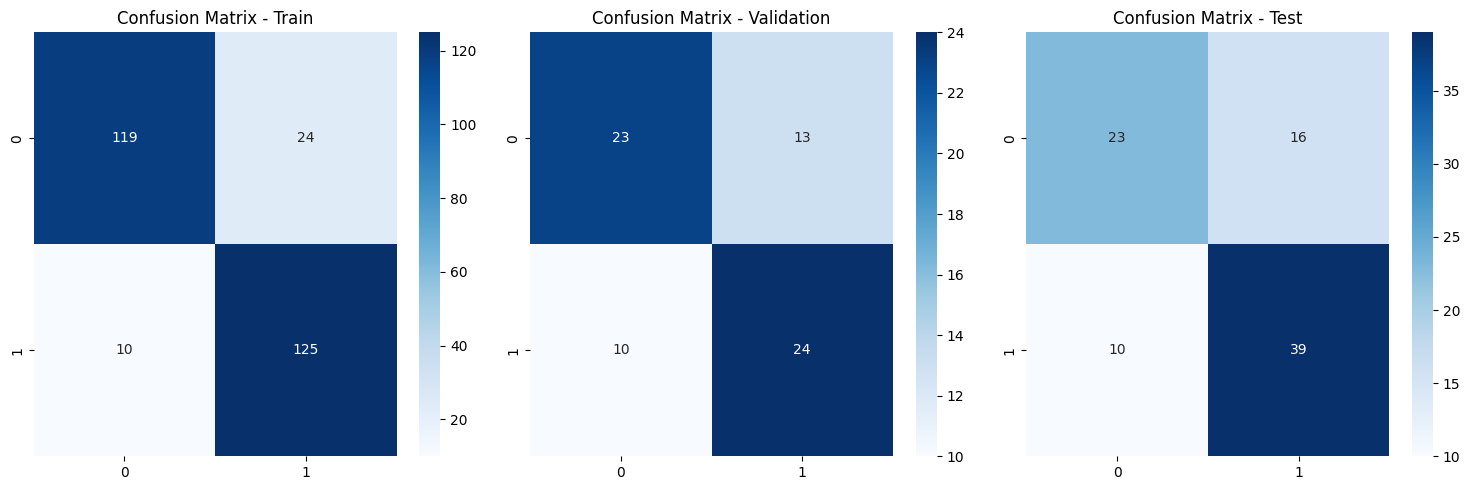

In [57]:
metrics_df = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

## 2.2 Ensemble Approach

We train separate ResNet-50
models for each MRI image type (T2W, DWI, and
ADC), and aggregate their predictions using a major-
ity voting system to get a unique diagnosis for each
patient. This approach makes use of the strengths of
each image type, potentially capturing more compre-
hensive diagnostic information

In [58]:
def make_dict_types(directory,t2w, multi_fold = False,  dict_images = {}):

  if multi_fold:
    print('fold')
    folds = os.listdir(directory)
    for f in folds:
      fold_path = os.path.join(directory, f)
      print(fold_path)
      make_dict(fold_path, False, dict_images)
    return dict_images
  else:
    print('datapoint')
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if t2w in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'age_group': None, 'patient_id': None}
    return dict_images


In [59]:
directory = "/Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1"
dict_t2w = make_dict_types(directory, "t2w")
dict_adc = make_dict_types(directory, "adc")
dict_cor = make_dict_types(directory, "cor")

datapoint
datapoint
datapoint


In [60]:
def matching(df , dict_images ):
    not_found = 0
    found = 0

    for f in df['full_name']:
        if f in dict_images:
            print(f"Found {f}")
            case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
            patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
            #converting to 0 and 1
            dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
            dict_images[f]['patient_age'] = patient_age
            dict_images[f]['patient_id'] = f

            age_group = categorize_age(patient_age)
            dict_images[f]['age_group'] = age_group


            found += 1
        else:
            print(f"Could not find {f}")
            not_found += 1
    

In [61]:
matching(df, dict_t2w)
matching(df, dict_adc)
matching(df, dict_cor)

Could not find 10000_1000000
Could not find 10001_1000001
Could not find 10002_1000002
Could not find 10003_1000003
Could not find 10004_1000004
Could not find 10005_1000005
Could not find 10006_1000006
Could not find 10007_1000007
Found 10008_1000008
Could not find 10009_1000009
Found 10010_1000010
Found 10011_1000011
Could not find 10012_1000012
Could not find 10013_1000013
Could not find 10014_1000014
Could not find 10015_1000015
Found 10016_1000016
Could not find 10017_1000017
Could not find 10018_1000018
Found 10019_1000019
Could not find 10020_1000020
Could not find 10021_1000021
Could not find 10022_1000022
Could not find 10023_1000023
Found 10024_1000024
Could not find 10025_1000025
Found 10026_1000026
Could not find 10027_1000027
Could not find 10028_1000028
Could not find 10029_1000029
Could not find 10030_1000030
Found 10031_1000031
Could not find 10032_1000032
Could not find 10033_1000033
Could not find 10034_1000034
Could not find 10035_1000035
Found 10036_1000036
Could no

In [62]:
dict_t2w

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3a77c52c0> >,
  'case_pca': 1,
  'patient_age': 76,
  'age_group': '65+',
  'patient_id': '10268_1000272'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3a77c5350> >,
  'case_pca': 0,
  'patient_age': 64,
  'age_group': '<65',
  'patient_id': '10892_1000908'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3a77bbf60> >,
  'case_pca': 1,
  'patient_age': 75,
  'age_group': '65+',
  'patient_id': '11385_1001409'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x3ccc17ba0> >,
  'case_pca': 0,
  'patient_age': 63,
  'age_group': '<65',
  'patient_id': '10401_1000407'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 

In [63]:
len(dict_t2w), len(dict_adc), len(dict_cor)

(298, 298, 298)

In [64]:
balanced_t2w = balance_dataset(dict_t2w)
balance_checker(dict_t2w)
balance_checker(balanced_t2w)



Count of 'YES': 77
Count of 'NO': 221
Count of 'YES': 221
Count of 'NO': 221


In [65]:
balanced_adc = balance_dataset(dict_adc)
balance_checker(dict_adc)


Count of 'YES': 77
Count of 'NO': 221


In [66]:
balanced_cor = balance_dataset(dict_cor)
balance_checker(dict_cor)

Count of 'YES': 77
Count of 'NO': 221


In [67]:
def running(balanced, forresnet):
    X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test = preprocess_data(balanced, forresnet)
    
    # Load pre-trained ResNet-50 model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
    x = Dense(128, activation='relu')(x)  # Add a dense layer
    predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

    # Combine the base model and new layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val))
    
    metrics_df = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

    prediction = model.predict(X_test)

    return metrics_df, prediction


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.815603,0.844961,0.773050,0.807407
Validation,0.676056,0.636364,0.656250,0.646154
Test,0.651685,0.707317,0.604167,0.651685


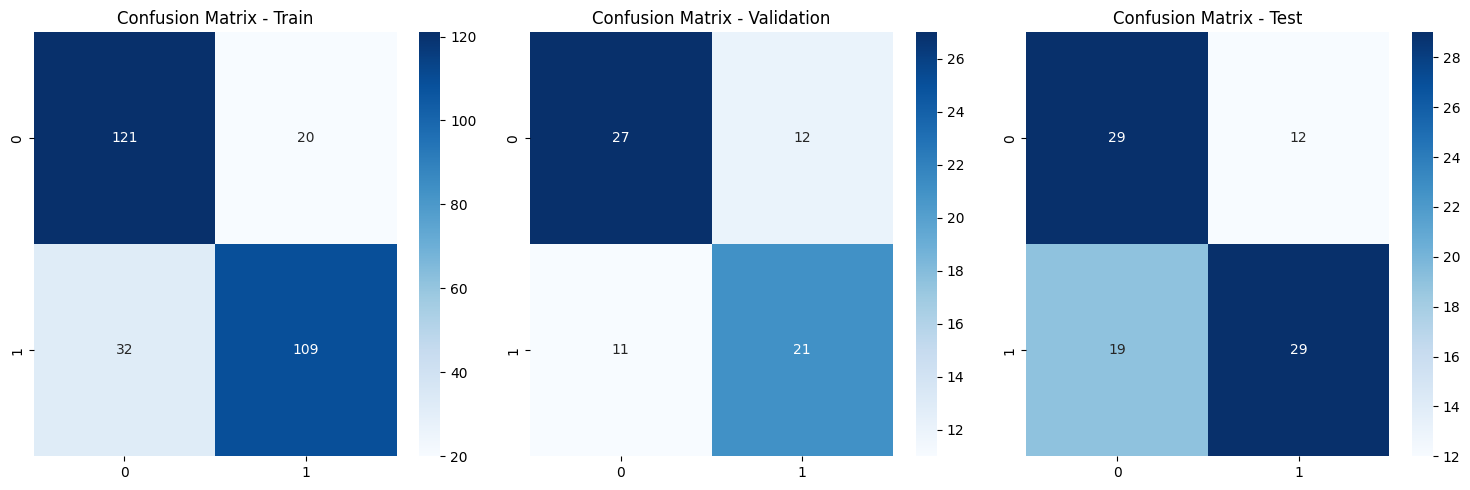

3/3 [==============================] - 2s 656ms/step


(            Accuracy  Precision    Recall  F1 Score
 Set Type                                           
 Train       0.815603   0.844961  0.773050  0.807407
 Validation  0.676056   0.636364  0.656250  0.646154
 Test        0.651685   0.707317  0.604167  0.651685,
 array([[0.4448    ],
        [0.5088589 ],
        [0.47166532],
        [0.7860098 ],
        [0.39862284],
        [0.93529356],
        [0.44219923],
        [0.5928624 ],
        [0.22422038],
        [0.1702759 ],
        [0.38123086],
        [0.60519534],
        [0.9355819 ],
        [0.24694161],
        [0.38123086],
        [0.43487087],
        [0.73559904],
        [0.48064423],
        [0.45237234],
        [0.77069473],
        [0.6861966 ],
        [0.33741033],
        [0.44404343],
        [0.6098078 ],
        [0.4377555 ],
        [0.5848236 ],
        [0.5535709 ],
        [0.40759227],
        [0.33087778],
        [0.29415804],
        [0.57415617],
        [0.2229188 ],
        [0.45351952],
        

In [68]:
running(balanced_t2w, forresnet)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.879433,0.845161,0.929078,0.885135
Validation,0.591549,0.542857,0.593750,0.567164
Test,0.685393,0.727273,0.666667,0.695652


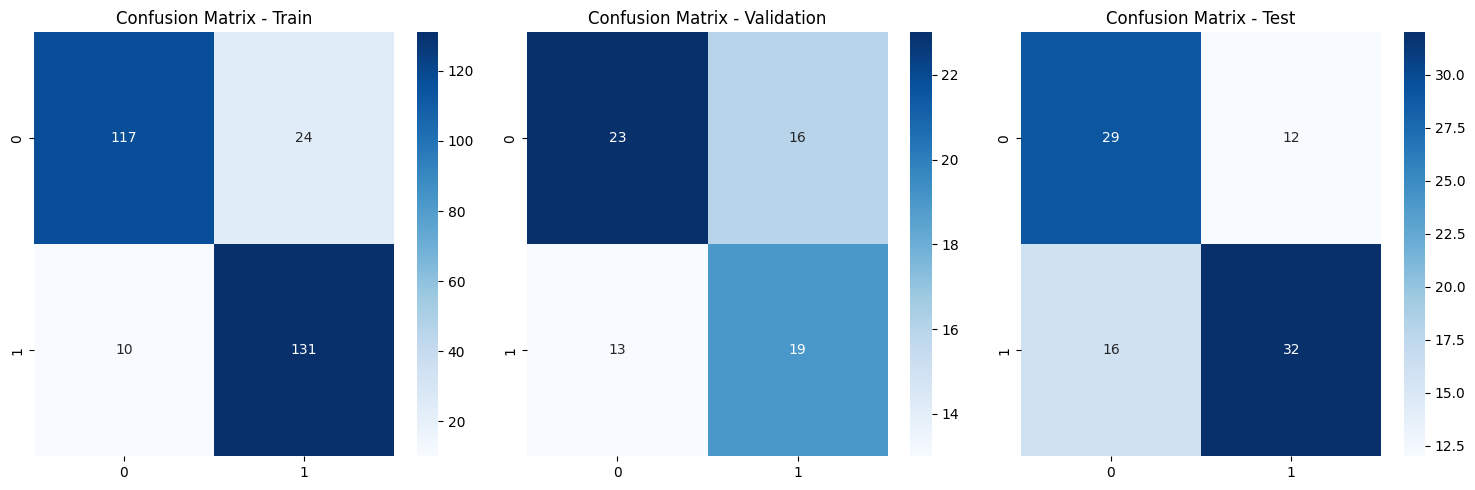

3/3 [==============================] - 3s 860ms/step


(            Accuracy  Precision    Recall  F1 Score
 Set Type                                           
 Train       0.879433   0.845161  0.929078  0.885135
 Validation  0.591549   0.542857  0.593750  0.567164
 Test        0.685393   0.727273  0.666667  0.695652,
 array([[0.45643672],
        [0.4251266 ],
        [0.63311756],
        [0.2724647 ],
        [0.37357658],
        [0.8179439 ],
        [0.8092171 ],
        [0.4432761 ],
        [0.2848632 ],
        [0.32441545],
        [0.37057677],
        [0.55523574],
        [0.2724647 ],
        [0.2536765 ],
        [0.51499784],
        [0.83285767],
        [0.6608038 ],
        [0.38118863],
        [0.65779424],
        [0.8179439 ],
        [0.61894584],
        [0.3115898 ],
        [0.37944385],
        [0.5644391 ],
        [0.5019299 ],
        [0.55848944],
        [0.53795356],
        [0.38444224],
        [0.11664412],
        [0.4364856 ],
        [0.83285767],
        [0.13983421],
        [0.41883305],
        

In [69]:
running(balanced_adc, forresnet)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.833333,0.793750,0.900709,0.843854
Validation,0.676056,0.615385,0.750000,0.676056
Test,0.707865,0.703704,0.791667,0.745098


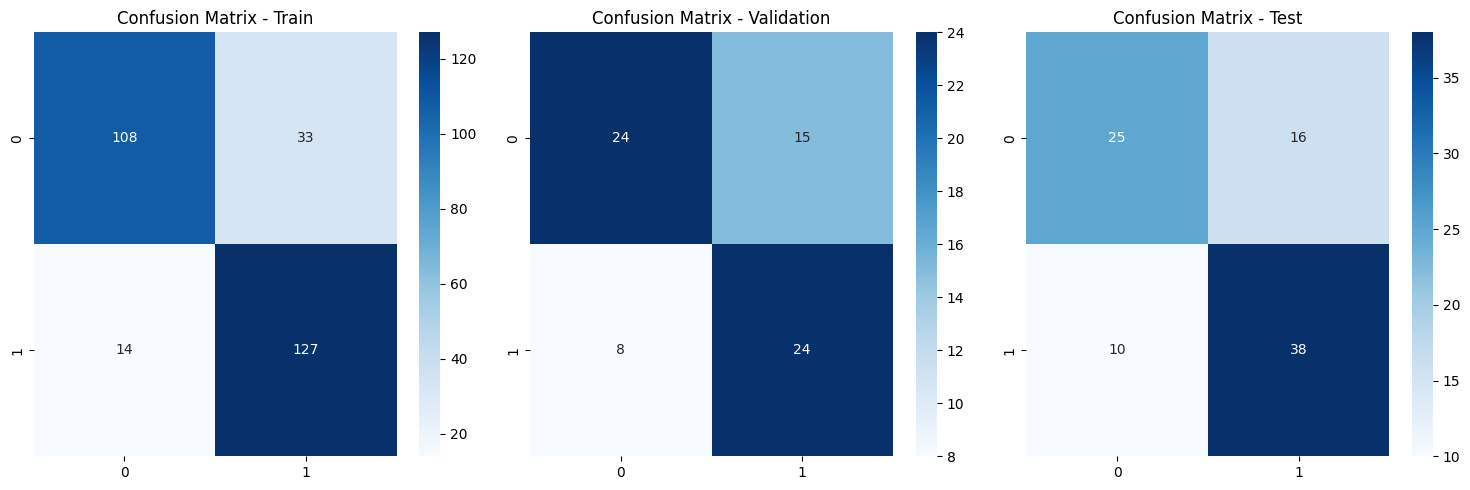

3/3 [==============================] - 2s 700ms/step


(            Accuracy  Precision    Recall  F1 Score
 Set Type                                           
 Train       0.833333   0.793750  0.900709  0.843854
 Validation  0.676056   0.615385  0.750000  0.676056
 Test        0.707865   0.703704  0.791667  0.745098,
 array([[0.5032655 ],
        [0.49190065],
        [0.61969197],
        [0.3380203 ],
        [0.46011868],
        [0.48825064],
        [0.57926846],
        [0.15999609],
        [0.13920054],
        [0.24902447],
        [0.48825064],
        [0.59149444],
        [0.8522009 ],
        [0.23740992],
        [0.47302583],
        [0.6911    ],
        [0.6631052 ],
        [0.4812039 ],
        [0.66484165],
        [0.6712242 ],
        [0.6678821 ],
        [0.37609166],
        [0.4046011 ],
        [0.8350929 ],
        [0.53803205],
        [0.61043465],
        [0.8094464 ],
        [0.49246323],
        [0.6788182 ],
        [0.40356934],
        [0.57926846],
        [0.2781112 ],
        [0.6073276 ],
        

In [70]:
running(balanced_cor, forresnet)

In [71]:
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

def running(balanced1, balanced2, balanced3, forresnet):
    # Assuming preprocess_data returns X_train, X_val, X_test, y_train, y_val, y_test, and age_test for each dataset
    X_train1, X_val1, X_test1, y_train1, y_val1, y_test1, age_train1, age_val1, age_test1 = preprocess_data(balanced1, forresnet)
    X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, age_train2, age_val2, age_test2 = preprocess_data(balanced2, forresnet)
    X_train3, X_val3, X_test3, y_train3, y_val3, y_test3, age_train3, age_val3, age_test3 = preprocess_data(balanced3, forresnet)

    # Preprocess each dataset
    datasets = [
        (X_train1, X_val1, X_test1, y_train1, y_val1, y_test1, age_test1),
        (X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, age_test2),
        (X_train3, X_val3, X_test3, y_train3, y_val3, y_test3, age_test3)
    ]
    
    # Load, train, and obtain predictions for each dataset
    predictions_all_datasets = []
    for X_train, X_val, X_test, y_train, y_val, y_test, age_test in datasets:
        # Load pre-trained ResNet-50 model without top layers
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # Add new classification layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
        x = Dense(128, activation='relu')(x)  # Add a dense layer
        predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

        # Combine the base model and new layers
        model = Model(inputs=base_model.input, outputs=predictions)

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
        
        # Get predictions on the test set
        predictions_test = model.predict(X_test)
        
        # Append predictions for this dataset
        predictions_all_datasets.append(predictions_test)
    
    # Perform majority voting across all datasets for each patient
    patient_predictions = {}
    for i in range(len(age_test1)):  # Assuming all datasets have the same length of age_test
        patient_id = age_test1[i]  # Assuming patient ID is stored in age_test1
        votes = [1 if pred[i] >= 0.5 else 0 for pred in predictions_all_datasets]  # Convert probabilities to votes (0 or 1)
        majority_vote = np.argmax(np.bincount(votes))  # Find the majority vote
        patient_predictions[patient_id] = majority_vote
    
    # Assuming y_true is the ground truth labels for the test set
    y_true = y_test1  # Use the labels from the first dataset for evaluation

    # Convert aggregated predictions to y_pred
    y_pred = np.array([patient_predictions[patient_id] for patient_id in age_test1])

    # Evaluate the aggregated predictions
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # Assuming y_pred is probabilities
    auc = roc_auc_score(y_true, y_pred)  # Assuming y_pred is probabilities

    # return patient_predictions, accuracy, precision, recall, f1, cm, fpr, tpr, auc
    print(accuracy)



In [72]:
running(balanced_t2w, balanced_adc, balanced_cor, forresnet)

Epoch 1/10
9/9 [==============================] - 11s 1s/step - loss: 0.7243 - accuracy: 0.5035 - val_loss: 0.6825 - val_accuracy: 0.5211
Epoch 2/10
9/9 [==============================] - 8s 933ms/step - loss: 0.6418 - accuracy: 0.6348 - val_loss: 0.6892 - val_accuracy: 0.5070
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.6090 - accuracy: 0.6879 - val_loss: 0.6330 - val_accuracy: 0.6197
Epoch 4/10
9/9 [==============================] - 9s 993ms/step - loss: 0.5844 - accuracy: 0.7057 - val_loss: 0.6460 - val_accuracy: 0.6338
Epoch 5/10
9/9 [==============================] - 9s 970ms/step - loss: 0.5565 - accuracy: 0.7128 - val_loss: 0.6172 - val_accuracy: 0.6620
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.5290 - accuracy: 0.7518 - val_loss: 0.6318 - val_accuracy: 0.6197
Epoch 7/10
9/9 [==============================] - 7s 778ms/step - loss: 0.5343 - accuracy: 0.7340 - val_loss: 0.5996 - val_accuracy: 0.6901
Epoch 8/10
9/9 [==========

# Experiment 3: Multimodal Model

## Preprocessing Tabular data post train-test split (normalizing age)

In [ ]:
scaler = StandardScaler()

#train
age_train = scaler.fit_transform(age_train.reshape(-1,1))

#test
age_val = scaler.transform(age_val.reshape(-1, 1))
age_test = scaler.transform(age_test.reshape(-1, 1))

## 3.1. Hybrid Embedding Fusion Approach

2 Approaches tested:

**Approach 1:** 
* This is like our baseline resnet50 model. 
* We get the output from the global average pooling layer, which gives us embeddings of dim 128 (we do more dimensionality reduction here; reduces complexity of model)


**Approach 2:**
* We are using pretrained resnet50 (no modifications) to get the embeddings from the second to last layer.
* No dimensionalirty reduction; will retain as mucho info from the image as we can. 
* Simpelr model architecture

### APPROACH 1

### Getting Image Embeddings

In [ ]:
base_model_32 = ResNet50(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  #  to get the embeddings
x = Dense(128, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Combine the base model and new layers
model_32 = Model(inputs = base_model.input, outputs = x)  #OUTPUT IS X BC EMBEDDINGS ARE IN SECOND TO LAST LAYER

# Extract embeddings from images
image_embeddings_train = model_32.predict(X_train)  
image_embeddings_val= model_32.predict(X_val)
image_embeddings_test = model_32.predict(X_test)

image_embeddings_train.shape

14/14 [==============================] - 8s 583ms/step


(1376, 128)

In [ ]:
def train_logistic_regression(age_train, age_val, age_test, image_embeddings_train, image_embeddings_val, image_embeddings_test, y_train, y_val, y_test, penalty='l2', max_iter=2000, threshold = 0.5):
    
    age_train_reshaped = age_train.reshape(-1, 1)
    age_test_reshaped = age_test.reshape(-1, 1)
    age_val_reshaped = age_val.reshape(-1, 1)

    # Concatenate image embeddings and age data
    X_train_combined = np.concatenate((image_embeddings_train, age_train_reshaped), axis = 1)
    X_test_combined = np.concatenate((image_embeddings_test, age_test_reshaped), axis = 1)

    # Initialize logistic regression model with specified penalty
    logistic_model = LogisticRegression(penalty = penalty, max_iter = max_iter)
    
    # Train the model
    logistic_model.fit(X_train_combined, y_train)
    
    #### for metrics
    X_test_combined = np.concatenate((image_embeddings_test, age_test_reshaped), axis = 1)
    X_val_combined = np.concatenate((image_embeddings_val, age_val_reshaped), axis = 1)
    
    metrics_df = evaluate_model(logistic_model, threshold, X_train_combined, y_train, X_val_combined, y_val, X_test_combined, y_test, include_test = True)

    return logistic_model, test_acc, metrics_df

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.681686,0.673360,0.721664,0.696676
Validation,0.677326,0.666667,0.686391,0.676385
Test,0.665116,0.632653,0.741627,0.682819


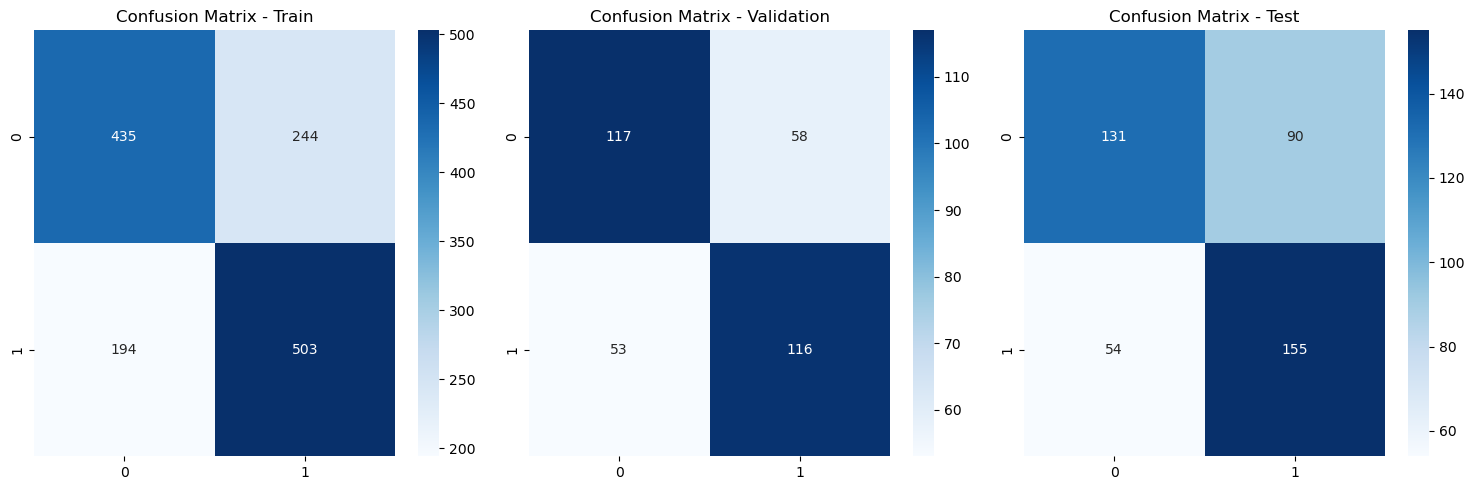

In [ ]:
logistic_model, test_acc, metrics_df = train_logistic_regression(age_train, age_val, age_test, image_embeddings_train, image_embeddings_val, image_embeddings_test, y_train, y_val, y_test, max_iter=2000)

### APPROACH 2

### Getting Image Embeddings

In [ ]:
# Load pre-trained ResNet50 model
resnet50 = ResNet50(weights='imagenet', include_top=False)

# Remove the top layer
x = resnet50.output
x = GlobalAveragePooling2D()(x)

# Create a new model with the desired layers
model = Model(inputs=resnet50.input, outputs=x)

# Freeze the layers
for layer in model.layers:
    layer.trainable = False

# Extract embeddings from images
image_embeddings_train = model.predict(X_train)  
image_embeddings_val = model.predict(X_val)
image_embeddings_test = model.predict(X_test)
image_embeddings_train.shape

14/14 [==============================] - 8s 557ms/step


(1376, 2048)

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.851744,0.840000,0.873745,0.856540
Validation,0.735465,0.703125,0.798817,0.747922
Test,0.727907,0.679688,0.832536,0.748387


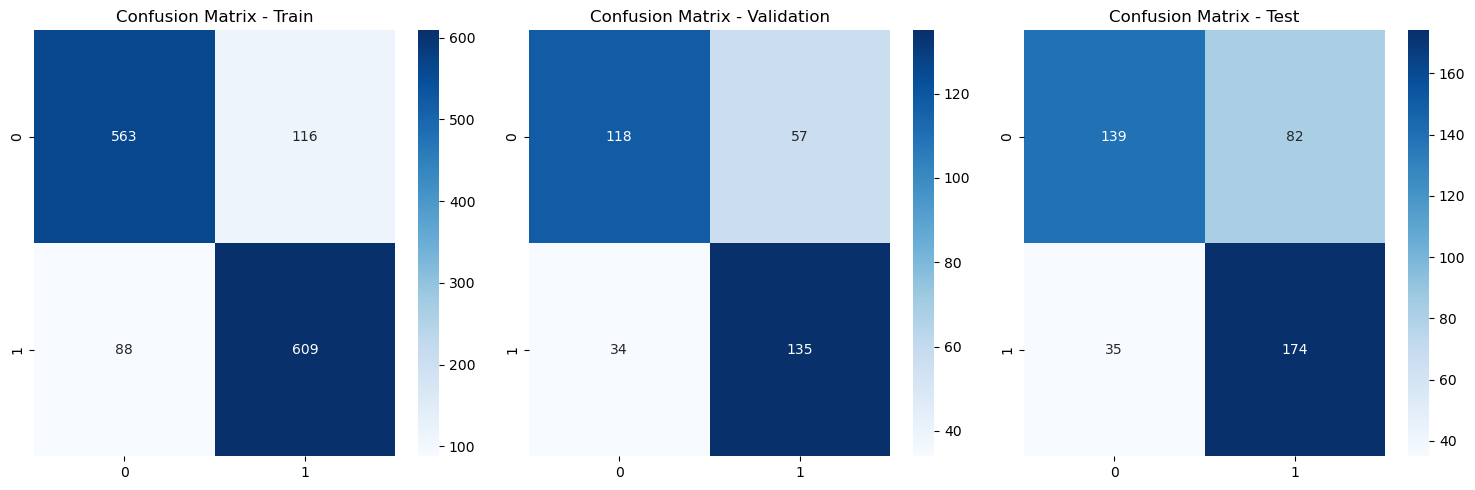

In [ ]:
logistic_model, test_acc, metrics_df = train_logistic_regression(age_train, age_val, age_test, image_embeddings_train, image_embeddings_val, image_embeddings_test, y_train, y_val, y_test, max_iter=2000)

## 3.2. Age-Tailored ResNet Modeling

Age groups for prostate cancer: 
* Younger than 50: rare
* 50 - 65: medium
* 65+ more frequent

Age of recommended to start discussions of first screening is at 50 years old if the individual is at average risk (according to the [American Cancer Society] https://www.cancer.org/cancer/types/prostate-cancer/detection-diagnosis-staging/acs-recommendations.html) . However, we don't have many individuals less than 50 years old in our dataset (31 only). 

Research has found that prstate cancer is most frequently diagnosed in men aged 65-74.https://seer.cancer.gov/statfacts/html/prost.html So we implemented the cutoff at 65 years old. We fit two distinct models: one for 'low risk/young individuals', one for 'high risk/older individuals'

In [ ]:
dict_images

{'10268_1000272': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431efd380> >,
  'case_pca': 1,
  'patient_age': 76,
  'patient_id': '10268_1000272',
  'age_group': '65+'},
 '10892_1000908': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431eff450> >,
  'case_pca': 0,
  'patient_age': 64,
  'patient_id': '10892_1000908',
  'age_group': '<65'},
 '11385_1001409': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431eff780> >,
  'case_pca': 1,
  'patient_age': 75,
  'patient_id': '11385_1001409',
  'age_group': '65+'},
 '10401_1000407': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x431efe460> >,
  'case_pca': 0,
  'patient_age': 63,
  'patient_id': '10401_1000407',
  'age_group': '<65'},
 '11371_1001394': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 

In [ ]:
balance_checker(dict_images)

Count of 'YES': 425
Count of 'NO': 1075


In [ ]:
def age_group_separator(group):
    new_dict = {}
    for key, entry in dict_images.items():
        if entry['age_group'] == group:
            new_dict[key] = entry
    return new_dict


young_df = age_group_separator('<65')
older_df = age_group_separator('65+')

In [ ]:
len(young_df), len(older_df)

(631, 869)

In [ ]:
balance_checker(young_df)

Count of 'YES': 128
Count of 'NO': 503


In [ ]:
balance_checker(older_df)

Count of 'YES': 297
Count of 'NO': 572


### UPSAMPLING: Balancing the young and older dictionaries for cases of Yes/No Cancer

In [ ]:
young_balanced_ups = balance_dataset(young_df)
older_balanced_ups = balance_dataset(older_df)

In [ ]:
balance_checker(young_balanced_ups)

Count of 'YES': 503
Count of 'NO': 503


In [ ]:
balance_checker(older_balanced_ups)

Count of 'YES': 572
Count of 'NO': 572


### Train test split for young and older df respectively

In [ ]:
X_train_young_ups, X_val_young_ups, X_test_young_ups, y_train_young_ups, y_val_young_ups, y_test_young_ups, age_train_young_ups, age_val_young_ups, age_test_young_ups = preprocess_data(young_balanced_ups)
X_train_old_ups, X_val_old_ups, X_test_old_ups, y_train_old_ups, y_val_old_ups, y_test_old_ups, age_train_old_ups, age_val_old_ups, age_test_old_ups = preprocess_data(older_balanced_ups)                                                                                                                                                    

In [ ]:
def build_and_resnet_1img_model(X_train, y_train, X_val, y_val, X_test, y_test, threshold):
    
    # Load pre-trained ResNet-50 model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    #freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    #new classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
    x = Dense(128, activation='relu')(x)  # Add a dense layer
    predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

    #combining base model and new layers
    model = Model(inputs = base_model.input, outputs = predictions)

    #compiling model
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights = True)


    #training
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    #evaluation
    metrics = evaluate_model(model, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

    return model, history, metrics

### Young Model - Upsampling

Epoch 1/10
21/21 [==============================] - 21s 793ms/step - loss: 0.6973 - accuracy: 0.5599 - val_loss: 0.6701 - val_accuracy: 0.5776
Epoch 2/10
21/21 [==============================] - 15s 729ms/step - loss: 0.6654 - accuracy: 0.6159 - val_loss: 0.6608 - val_accuracy: 0.6149
Epoch 3/10
21/21 [==============================] - 15s 724ms/step - loss: 0.6168 - accuracy: 0.6547 - val_loss: 0.6706 - val_accuracy: 0.5466
Epoch 4/10
21/21 [==============================] - 15s 728ms/step - loss: 0.5574 - accuracy: 0.6952 - val_loss: 0.5962 - val_accuracy: 0.6957
Epoch 5/10
21/21 [==============================] - 15s 714ms/step - loss: 0.5470 - accuracy: 0.7061 - val_loss: 0.5588 - val_accuracy: 0.6832
Epoch 6/10
21/21 [==============================] - 15s 709ms/step - loss: 0.5142 - accuracy: 0.7652 - val_loss: 0.5327 - val_accuracy: 0.7081
Epoch 7/10
21/21 [==============================] - 15s 697ms/step - loss: 0.4865 - accuracy: 0.8009 - val_loss: 0.5353 - val_accuracy: 0.7764

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.819596,0.754177,0.960486,0.844920
Validation,0.726708,0.698113,0.860465,0.770833
Test,0.688119,0.589928,0.931818,0.722467


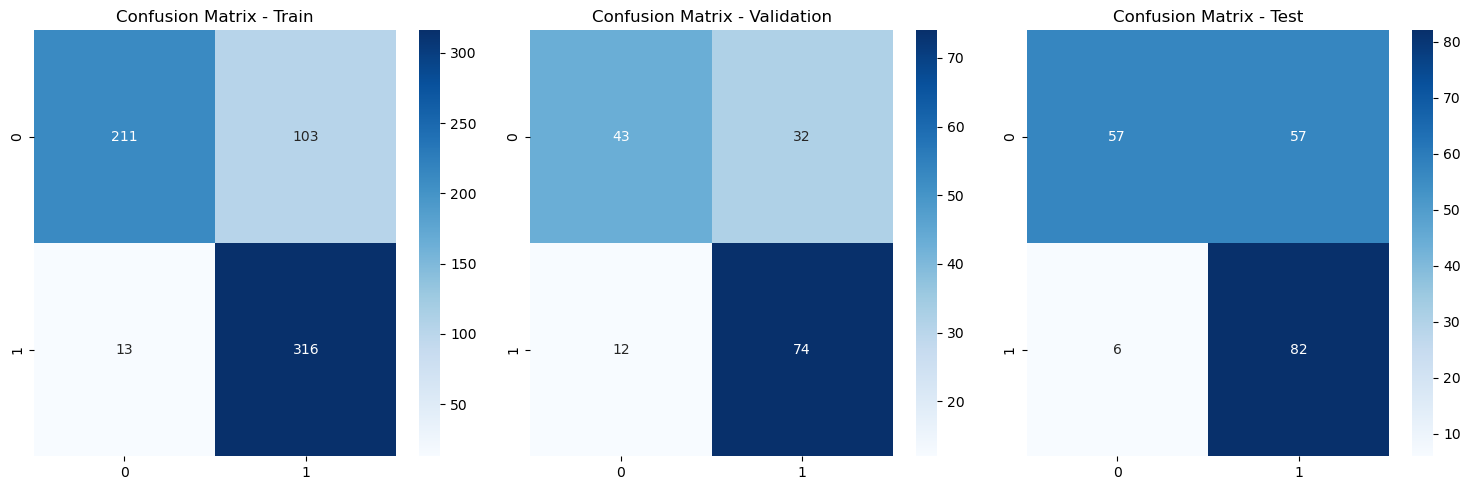

In [ ]:
model_young_ups, history_young_ups, metrics_young_ups = build_and_resnet_1img_model(X_train_young_ups, y_train_young_ups, X_val_young_ups, y_val_young_ups, X_test_young_ups, y_test_young_ups, 0.5)

### Older Model - Upsampling

Epoch 1/10
23/23 [==============================] - 21s 801ms/step - loss: 0.7111 - accuracy: 0.5178 - val_loss: 0.6720 - val_accuracy: 0.5464
Epoch 2/10
23/23 [==============================] - 18s 784ms/step - loss: 0.6566 - accuracy: 0.6079 - val_loss: 0.6564 - val_accuracy: 0.6120
Epoch 3/10
23/23 [==============================] - 19s 851ms/step - loss: 0.6394 - accuracy: 0.6216 - val_loss: 0.6405 - val_accuracy: 0.6612
Epoch 4/10
23/23 [==============================] - 17s 763ms/step - loss: 0.6144 - accuracy: 0.6585 - val_loss: 0.6498 - val_accuracy: 0.5847
Epoch 5/10
23/23 [==============================] - 18s 772ms/step - loss: 0.5918 - accuracy: 0.6749 - val_loss: 0.6443 - val_accuracy: 0.6393
Epoch 6/10
23/23 [==============================] - 17s 757ms/step - loss: 0.5815 - accuracy: 0.7036 - val_loss: 0.6355 - val_accuracy: 0.6448
Epoch 7/10
23/23 [==============================] - 17s 756ms/step - loss: 0.5713 - accuracy: 0.7036 - val_loss: 0.6254 - val_accuracy: 0.6721

,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.732240,0.737789,0.753281,0.745455
Validation,0.672131,0.677419,0.677419,0.677419
Test,0.598253,0.525862,0.622449,0.570093


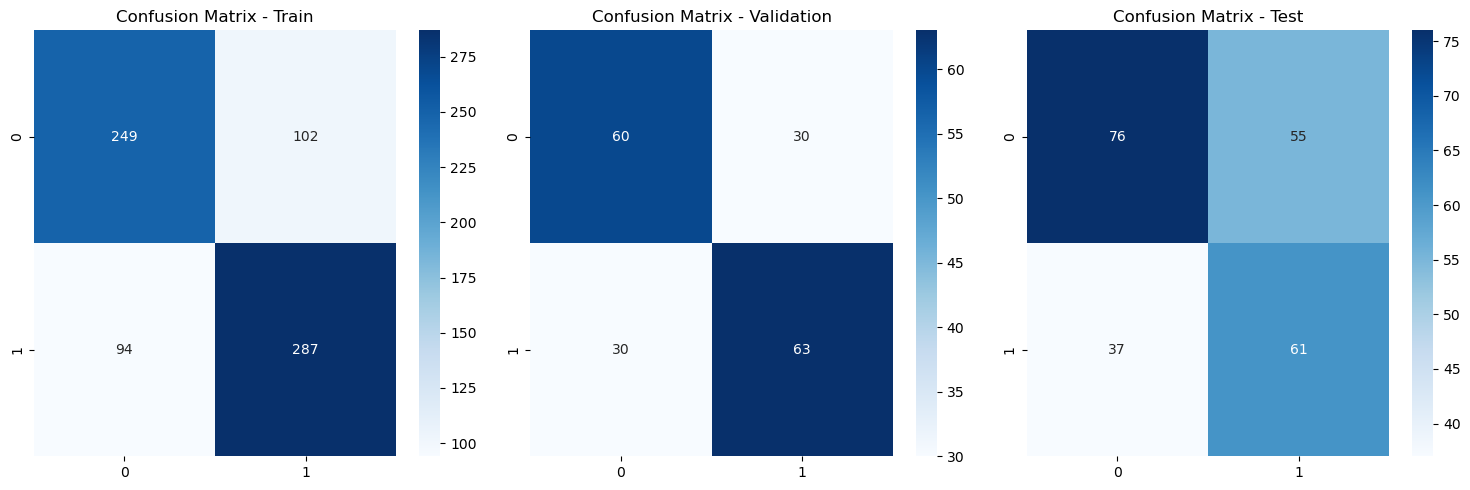

In [ ]:
model_old_ups, history_old_ups, metrics_old_ups = build_and_resnet_1img_model(X_train_old_ups, y_train_old_ups, X_val_old_ups, y_val_old_ups, X_test_old_ups, y_test_old_ups, 0.5)

### DOWNSAMPLING - Balancing the young and older dictionaries for cases of Yes/No Cancer

In [ ]:
young_balanced_down = balance_dataset(young_df, sampling = 'downsampling')
older_balanced_down = balance_dataset(older_df, sampling = 'downsampling')

In [ ]:
balance_checker(young_balanced_down)

Count of 'YES': 128
Count of 'NO': 128


In [ ]:
balance_checker(older_balanced_down)

Count of 'YES': 297
Count of 'NO': 297


#### Train test split

In [ ]:
X_train_young_down, X_val_young_down, X_test_young_down, y_train_young_down, y_val_young_down, y_test_young_down, age_train_young_down, age_val_young_down, age_test_young_down = preprocess_data(young_balanced_down)
X_train_old_down, X_val_old_down, X_test_old_down, y_train_old_down, y_val_old_down, y_test_old_down, age_train_old_down, age_val_old_down, age_test_old_down = preprocess_data(older_balanced_down)                                                                                                                                                    

### Young Model - Downsample

Epoch 1/10
6/6 [==============================] - 7s 791ms/step - loss: 0.8425 - accuracy: 0.4724 - val_loss: 0.7146 - val_accuracy: 0.4390
Epoch 2/10
6/6 [==============================] - 4s 690ms/step - loss: 0.6371 - accuracy: 0.6380 - val_loss: 0.7080 - val_accuracy: 0.5366
Epoch 3/10
6/6 [==============================] - 4s 646ms/step - loss: 0.6186 - accuracy: 0.6994 - val_loss: 0.7302 - val_accuracy: 0.5122
Epoch 4/10
6/6 [==============================] - 4s 712ms/step - loss: 0.5918 - accuracy: 0.6933 - val_loss: 0.7732 - val_accuracy: 0.4634
Epoch 5/10
2/2 [==============================] - 1s 410ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.687117,0.708333,0.629630,0.666667
Validation,0.536585,0.571429,0.380952,0.457143
Test,0.576923,0.576923,0.576923,0.576923


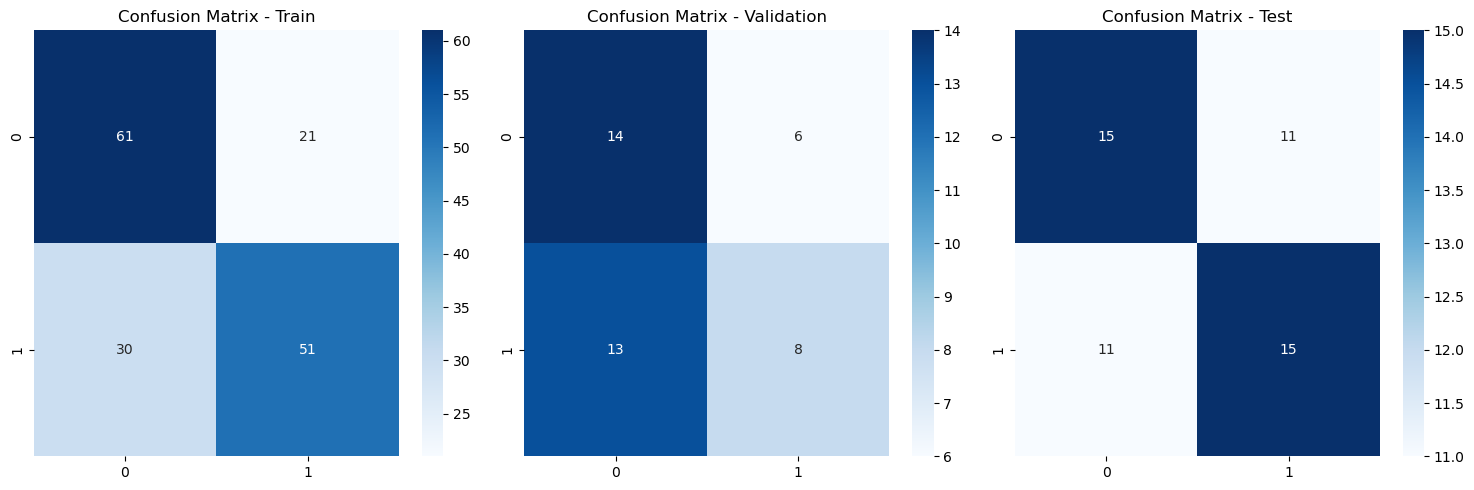

In [ ]:
model_young_down, history_young_down, metrics_young_down = build_and_resnet_1img_model(X_train_young_down, y_train_young_down, X_val_young_down, y_val_young_down, X_test_young_down, y_test_young_down, 0.5)

### Older Model  - Downsample

Epoch 1/10
12/12 [==============================] - 12s 873ms/step - loss: 0.7338 - accuracy: 0.4684 - val_loss: 0.6977 - val_accuracy: 0.5263
Epoch 2/10
12/12 [==============================] - 9s 780ms/step - loss: 0.6941 - accuracy: 0.5447 - val_loss: 0.7139 - val_accuracy: 0.4526
Epoch 3/10
12/12 [==============================] - 9s 790ms/step - loss: 0.6613 - accuracy: 0.5605 - val_loss: 0.6983 - val_accuracy: 0.5158
Epoch 4/10
4/4 [==============================] - 2s 557ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.586842,0.610294,0.443850,0.513932
Validation,0.526316,0.636364,0.274510,0.383562
Test,0.596639,0.622222,0.474576,0.538462


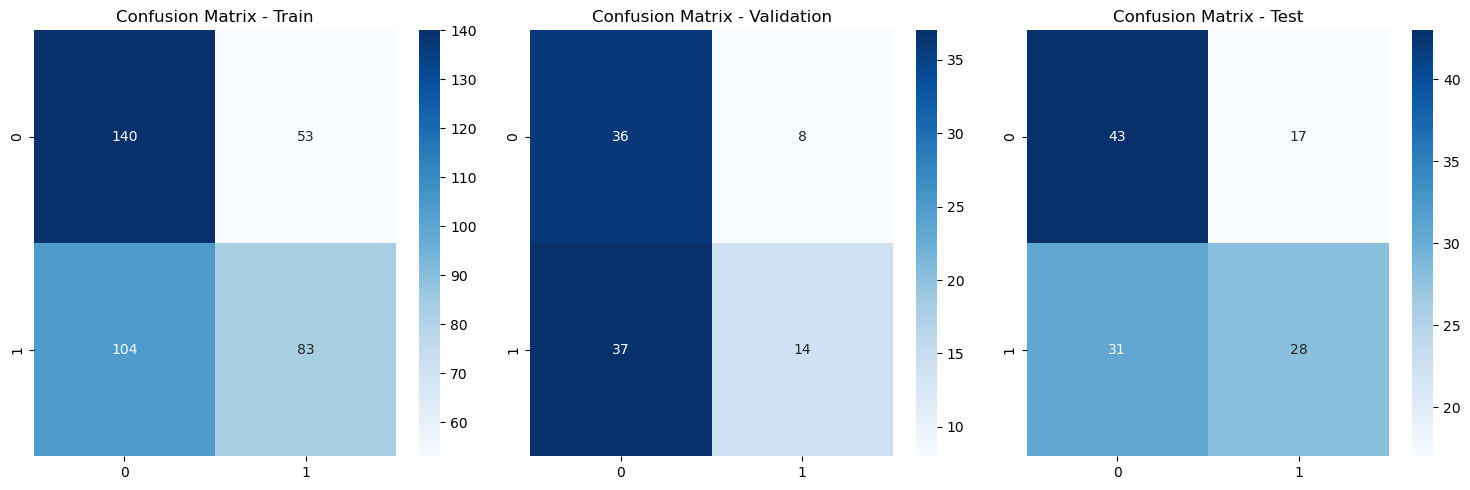

In [ ]:
model_old_down, history_old_down, metrics_old_down = build_and_resnet_1img_model(X_train_old_down, y_train_old_down, X_val_old_down, y_val_old_down, X_test_old_down, y_test_old_down, 0.5)